<a href="https://colab.research.google.com/github/xTavi/BlackBoxAttack/blob/master/BlackBoxAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
from matplotlib import pyplot
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
import torch.onnx
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
# import utils
import math
import random
import pdb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# class containing parameters for CNN optimizer  
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10#10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# code to download MNIST datasets for first method
# loaders for train and test data, respectively
# the data will be in pytorch tensor format

train_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True,drop_last=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
# change folder to keep track later on
# note - don't change before downloading the MINST data
os.chdir("/content/gdrive/My Drive/")
# data is saved in the main directory in google drive

In [5]:
# arhitecture for CNN
# will use those same parameters in the following cells
# serves as a starting point for fully connected CNN
number_of_filters_1 = 20
number_of_filters_2 = 50
nn1 = 500
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, number_of_filters_1, 5, 1)
        self.conv2 = nn.Conv2d(number_of_filters_1, number_of_filters_2, 5, 1)
        self.fc1 = nn.Linear(4*4*number_of_filters_2, nn1)
        # 10 classes, one for each digit
        self.fc2 = nn.Linear(nn1, 10)

    def forward(self, x):
        # activation functions
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*number_of_filters_2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# define a function for training and testing, respectively
# similar to what we have done in the laboratory
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # use batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # print loss at every step of the way
        if batch_idx % args.log_interval == 0:
            print('Train data performance for epoch {}:  for {:.0f}% of the data we have loss: {:.6f}'.format(epoch, 100. * batch_idx / len(train_loader), loss.item()))
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    # for accuracy we will
    # keep track of how many correct items classified as a percentage of total
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True) 
            # increment correctly classified items
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of examples to get average loss
    test_loss /= len(test_loader.dataset)
    # print average loss and accuracy on test data
    print('Computing accuracy on the test data: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
# create and train, test our CNN
model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

# we save the model to save parameters for later
torch.save(model.state_dict(),"conv_net.pt")

Train data performance for epoch 1:  for 0% of the data we have loss: 2.301512
Train data performance for epoch 1:  for 17% of the data we have loss: 0.418920
Train data performance for epoch 1:  for 33% of the data we have loss: 0.218822
Train data performance for epoch 1:  for 50% of the data we have loss: 0.129434
Train data performance for epoch 1:  for 67% of the data we have loss: 0.006026
Train data performance for epoch 1:  for 83% of the data we have loss: 0.042212
Train data performance for epoch 1:  for 100% of the data we have loss: 0.069779
Computing accuracy on the test data: Average loss: 0.0671, Accuracy: 9764/10000 (98%)
Train data performance for epoch 2:  for 0% of the data we have loss: 0.082649
Train data performance for epoch 2:  for 17% of the data we have loss: 0.011427
Train data performance for epoch 2:  for 33% of the data we have loss: 0.018786
Train data performance for epoch 2:  for 50% of the data we have loss: 0.198629
Train data performance for epoch 2:

Epsilons: List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1], no epsilon value should exceed 1.

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "conv_net.pt"
use_cuda=True

In [9]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = CNN().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model.eval()

CUDA Available:  False


CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Let's do a black box SimBa attack

In [46]:
#Here we add the element we need 

adv = []
number_of_correct = 0

In [47]:
def get_probs(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs(model, (x - diff.view(x.size())).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size())).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        if prediction != y:
          adv.append((y.item(), prediction.item(), x))
          break

    return x

We can attack now

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor(1)
torch.Size([1, 28, 28]) torch.Size([])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


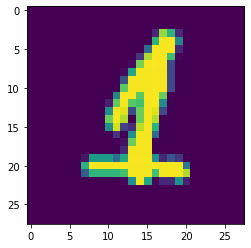

In [ ]:
# This is not good

for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        plt.imshow(data[0][0])
        print(data.size(), target.size())
        print(torch.nn.Softmax()(output[0]).argmax())
        x = data[0]
        y = target[0]
        print(x.size(), y.size())
        break


In [48]:
#copy 
for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        initial_predictions = model(data)
        initial_predictions = initial_predictions.argmax(dim=1, keepdim=True)
        initial_correctness = 0
        initial_correctness += initial_predictions.eq(target.view_as(initial_predictions)).sum().item()
        
        print(f'Initial accuracy for batch {batch_idx}/{ math.floor(len(test_loader.dataset)/len(data)) } was ', 100.  * initial_correctness / len(target), "%")

        bigger_result = torch.zeros(1,1,28,28)
        for x, y in zip(data,target):
          x = x.unsqueeze(dim=0)
          result = simba_single(model, x, y, 784, 0.05)
          result.unsqueeze(dim=0)
          bigger_result = torch.cat((bigger_result, result))

        final_result = bigger_result[1:]
        final_predictions = model(final_result).argmax(dim=1, keepdim=True)
        final_corectness = 0
        final_corectness += final_predictions.eq(target.view_as(final_predictions)).sum().item()
        number_of_correct += final_corectness
        
        print(f'Final accuracy for batch {batch_idx}/{math.floor(len(test_loader.dataset)/len(data))  } was ', 100.  * final_corectness / len(target),"%")
        break;


Initial accuracy for batch 0/156 was  100.0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Final accuracy for batch 0/156 was  96.875 %


In [49]:
len(adv)

2

In [ ]:
bigger_result[0]
another_result = bigger_result[1:]
another_result.size()

torch.Size([64, 1, 28, 28])

In [ ]:
xx = x.unsqueeze(dim=0)
print(y)
new_output = model(xx)
print(new_output.argmax())

tensor(1)
tensor(1)


In [50]:
# plt.imshow(  x.permute(1, 2, 0)  )
plt.imshow(xx[0][0], cmap='gray')

NameError: ignored

In [ ]:
n_dims = xx.view(1, -1).size(1)
perm = torch.randperm(n_dims)

In [51]:
adversarial = simba_single(model, xx, y, 784)

print(adversarial.size())

NameError: ignored

In [ ]:
print(adv[0][2])

tensor(9)


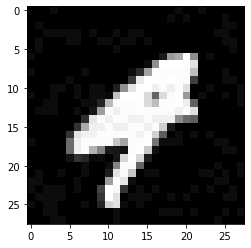

In [57]:
plt.imshow(adv[len(adv)-2][2][0][0], cmap='gray')

bad_output = model(adv[0][2])
print(bad_output.argmax())

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]


In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        init_pred = init_pred.squeeze()
        # If the initial prediction is wrong, dont bother attacking, just move on

        # print(init_pred[0].item())
        # print(target[0].item())

        if init_pred[0].item() != target[0].item():
            continue

        for 

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred[0].item() == target[0].item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples